<img src='https://gazetadasemana.com.br/images/noticias/78040/30064552_altaLOGOS_.png.png' width=500>

# Data Treatment: Feature Selection(Lasso Regression) and Feature Extraction(PCA)
Authorship: Raul Macedo

In [1]:
#General imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas import DataFrame
import prince
import os

Initially, the purpose of this analysis is to observe the data related to failure 5 of 3W. For this, all REAL instances of NORMAL operation and EVENT 5 were merged into a single dataset, including two columns: 'file_name' and 'event', which identify the instance that generated the data and the event (0 for normal and 5 for the actual failure).

In [2]:
master5_df = pd.read_csv('./main_class_five_&_zero.csv')

Displaying data sample

In [3]:
master5_df=master5_df.drop('Unnamed: 0',axis=1)
master5_df.head()

,timestamp,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class,file_name,event
0,2017-05-27 06:00:00.000000,0.0,14221150.0,116.6691,6111811.0,68.71003,3012952.0,NaN,0.0,0.0,WELL-00001_20170527060000.csv,0
1,2017-05-27 06:00:01.000000,0.0,14221260.0,116.6691,6111408.0,68.71239,3012952.0,NaN,0.0,0.0,WELL-00001_20170527060000.csv,0
2,2017-05-27 06:00:02.000000,0.0,14221370.0,116.6692,6111005.0,68.71474,3012951.0,NaN,0.0,0.0,WELL-00001_20170527060000.csv,0
3,2017-05-27 06:00:03.000000,0.0,14221480.0,116.6693,6110601.0,68.71710,3012951.0,NaN,0.0,0.0,WELL-00001_20170527060000.csv,0
4,2017-05-27 06:00:04.000000,0.0,14221590.0,116.6693,6110198.0,68.71946,3012951.0,NaN,0.0,0.0,WELL-00001_20170527060000.csv,0


Separating the normal operation instances from the failure operation instances.


In [4]:
normal_op = master5_df[master5_df['event']==0].copy()
PRP = master5_df[master5_df['event']==5].copy()
len(PRP) #Total of failure operation vectors

361998

Checking if feature T-JUS-CKGL only contains NaN values

In [5]:
len(PRP['T-JUS-CKGL']) == len(np.isnan(PRP['T-JUS-CKGL']))

True

**Correlation matrix**

Next, the initial intention was to plot a spearman correlation heatmap without any preliminary data treatments. However, to facilitate readability, the variable T-JUS-CKGL was removed since all its values are NaN.

The columns "event" and "class" were also removed as they do not have physical meaning. For further use, the variable `PRP_with_class` was created. (The "file_name" column is naturally disregarded as it lacks numerical value.)

Note: "class" was considered in the correlation matrices as it is the output in the prediction model.

In [6]:
PRP_with_class = PRP.drop(columns=['T-JUS-CKGL','event']).copy()
PRP = PRP_with_class.drop(columns=['class']).copy()

--- 
**Spearman Correlation** 

In [7]:
corr_spearman = PRP_with_class.iloc[:,:].corr(method='spearman')

/tmp/ipykernel_425790/1568964093.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_spearman = PRP_with_class.iloc[:,:].corr(method='spearman')


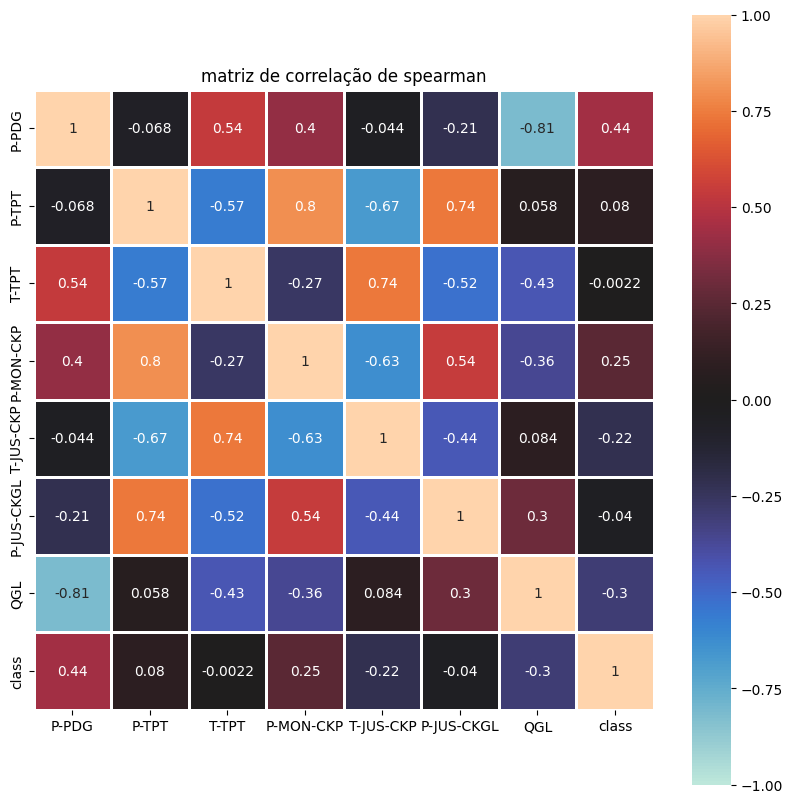

In [8]:

fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(corr_spearman,
                 vmin=-1, 
                 vmax=1, 
                 center=0,
                 square=True,
                 annot=True,
                 linewidths=0.8) 
ax.set_ylim(len(corr_spearman), 0) 
plt.title('matriz de correlação de spearman')
plt.show()

**Kendall Correlation**

In [10]:
corr_kendall = PRP_with_class.iloc[:,:].corr(method='kendall')

/tmp/ipykernel_425790/1491072503.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_kendall = PRP_with_class.iloc[:,:].corr(method='kendall')
/home/rforonda@hu.corp/Documentos/Personal/PUC/TCC/3W_EVALUATION/venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


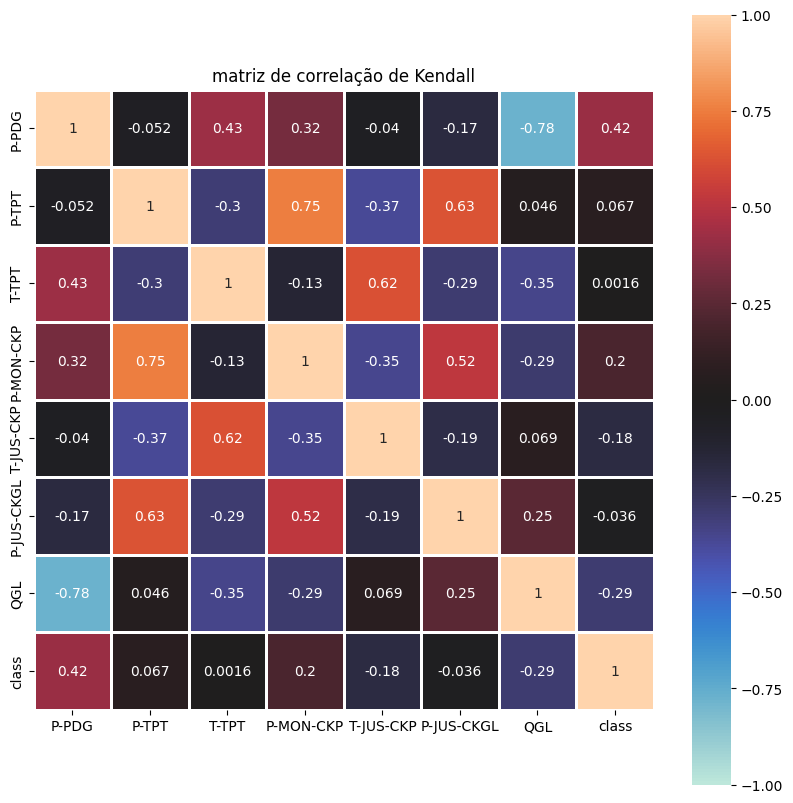

In [11]:

fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(corr_kendall,
                 vmin=-1, 
                 vmax=1, 
                 center=0,
                 square=True,
                 annot=True,
                 linewidths=0.8) 
ax.set_ylim(len(corr_kendall), 0)
plt.title('matriz de correlação de Kendall')
plt.show()

**INITIAL DATA TREATMENT**

Initially, we need to identify the occurrence of irregular data, such as NaN or negative values, in the event instances present in the PRP subdataset.

In [12]:

text_columns = ['timestamp','file_name']

In [13]:
#Finding non numerical values (NaN,null)
PRP_non_text_column = PRP_with_class.drop(columns=text_columns).copy()
PRP_non_text_column.isnull().sum() + PRP_non_text_column.isna().sum() 

P-PDG            0
P-TPT            0
T-TPT            0
P-MON-CKP        0
T-JUS-CKP        0
P-JUS-CKGL       0
QGL              0
class         2922
dtype: int64

In [15]:
#Finding values lower than 0 
PRP_non_text_column.lt(0).sum()

P-PDG         0
P-TPT         0
T-TPT         0
P-MON-CKP     0
T-JUS-CKP     0
P-JUS-CKGL    0
QGL           0
class         0
dtype: int64

In [16]:
# Fiding values equal to 0
PRP_non_text_column.eq(0).sum()

P-PDG              0
P-TPT           7754
T-TPT           7754
P-MON-CKP          0
T-JUS-CKP          0
P-JUS-CKGL         0
QGL           335472
class          32232
dtype: int64

OBS: For the variable class, values equal to 0 should not be considered a problem as they represent normal operation state.

For the variables P-TPT, T-TPT, and QGL, it is possible to observe a significant number of values equal to 0. Thus, it is necessary to determine the occurrence locations to understand the feasibility of filling these values with linear interpolation.

- First, we observe whether this is a common behavior across all instances or only specific instances at certain times.

In [17]:
# Instances and their respective total sizes.
files_and_sizes = PRP.groupby(PRP['file_name'],as_index=False,dropna=False).size().copy()
files_and_sizes

,file_name,size
0,WELL-00015_20170620160349.csv,11182
1,WELL-00015_20171013140047.csv,7754
2,WELL-00016_20180405020345.csv,3311
3,WELL-00016_20180426142005.csv,1440
4,WELL-00016_20180426145108.csv,3193
5,WELL-00016_20180517222322.csv,11974
6,WELL-00017_20140314180000.csv,136538
7,WELL-00017_20140317151743.csv,35754
8,WELL-00017_20140318023141.csv,41178
9,WELL-00017_20140318160220.csv,35861


In [18]:
def add_file_original_size(row):
  return len(PRP[PRP['file_name']==row['file_name']])


Files that have zero values for P-TPT.

In [20]:
PRP_PTPT_ZERO = PRP[PRP['P-TPT'].eq(0)==True].groupby(PRP['file_name'],as_index=False,dropna=False).size()
PRP_PTPT_ZERO['instance_original_size'] = PRP_PTPT_ZERO.apply(add_file_original_size,axis=1)
PRP_PTPT_ZERO=PRP_PTPT_ZERO.rename(columns={'size':'Quantity of zeros P-TPT'})
PRP_PTPT_ZERO

,file_name,Quantity of zeros P-TPT,instance_original_size
0,WELL-00015_20171013140047.csv,7754,7754


Files that have zero values for T-TPT.

In [21]:
PRP_TTPT_ZERO = PRP[PRP['T-TPT'].eq(0)==True].groupby(PRP['file_name'],as_index=False,dropna=False).size()
PRP_TTPT_ZERO['instance_original_size'] = PRP_TTPT_ZERO.apply(add_file_original_size,axis=1)
PRP_TTPT_ZERO=PRP_TTPT_ZERO.rename(columns={'size':'Quantity of zeros T-TPT'})

PRP_TTPT_ZERO

,file_name,Quantity of zeros T-TPT,instance_original_size
0,WELL-00015_20171013140047.csv,7754,7754


Relation between size of instances and quantity of zeros in QGL

In [22]:
def count_zeros(row,**kwargs):
  column_to_count_zeros = kwargs['column_to_count_zeros']
  return len(PRP[(PRP['file_name']==row['file_name']) & (PRP[column_to_count_zeros] == 0)])

QGL_ZEROS_DF = files_and_sizes.copy()
QGL_ZEROS_DF['Quantity of zeros QGL'] = QGL_ZEROS_DF.apply(count_zeros,axis=1,column_to_count_zeros='QGL')
QGL_ZEROS_DF = QGL_ZEROS_DF.rename(columns={'size':'Instance Original Size'}).copy()
QGL_ZEROS_DF

,file_name,Instance Original Size,Quantity of zeros QGL
0,WELL-00015_20170620160349.csv,11182,5087
1,WELL-00015_20171013140047.csv,7754,2923
2,WELL-00016_20180405020345.csv,3311,0
3,WELL-00016_20180426142005.csv,1440,9
4,WELL-00016_20180426145108.csv,3193,18
5,WELL-00016_20180517222322.csv,11974,4291
6,WELL-00017_20140314180000.csv,136538,136538
7,WELL-00017_20140317151743.csv,35754,35754
8,WELL-00017_20140318023141.csv,41178,41178
9,WELL-00017_20140318160220.csv,35861,35861


As observed, only the instance WELL-00015_20171013140047.csv had zero values for both P-TPT and T-TPT variables. It was expected that the variable QGL would not have values since, in theory, the wells in this operation do not operate with gas-lift due to being flowing wells. However, 6 out of the 12 instances had values for QGL.

_The identification of NaN values in `class` should be observed in the next sessions._

Since only one instance had zero values for P-TPT and T-TPT variables, there are two options that can be followed:

- Disregard the instance WELL-00015_20171013140047.csv, considering that in this instance, there was a failure in the pressure and temperature sensors, leading to this behavior.
- Fill these data with the same values from instances with similar sizes, taking into account the class.

In [23]:

# Dataframes de PRP separados
dfs_by_instances = [PRP_with_class[PRP['file_name'] == filename] for filename in list(files_and_sizes['file_name']) ]


In [24]:
instance_with_P_T_zeros='WELL-00015_20171013140047.csv'

In [25]:
colors = ['#FF0000', '#0000FF', '#00FF00', '#FFFF00', '#00FFFF', '#FF00FF', '#000000', '#FFFF00', '#FFA500', '#A52A2A', '#808080', '#800080']


In [26]:
def instancesSpan(df:DataFrame,x_map:dict):
  for i,instance in enumerate(dfs_by_instances):
      get_val = lambda iloc_index : df.loc[df['timestamp']==instance['timestamp'].iloc[iloc_index]]
      mi_v = get_val(0)
      ma_v = get_val(-1)
      if mi_v.empty or ma_v.empty:
          continue
      min_val = x_map[list(mi_v['timestamp'])[0]]
      max_val = x_map[list(ma_v['timestamp'])[0]]
      ax.axvspan(xmin=min_val,xmax=max_val,color=colors[i],alpha=0.1)



* Plot P-TPT by timestamp, taking into account the instance `WELL-00015_20171013140047.csv`(contain zeros).

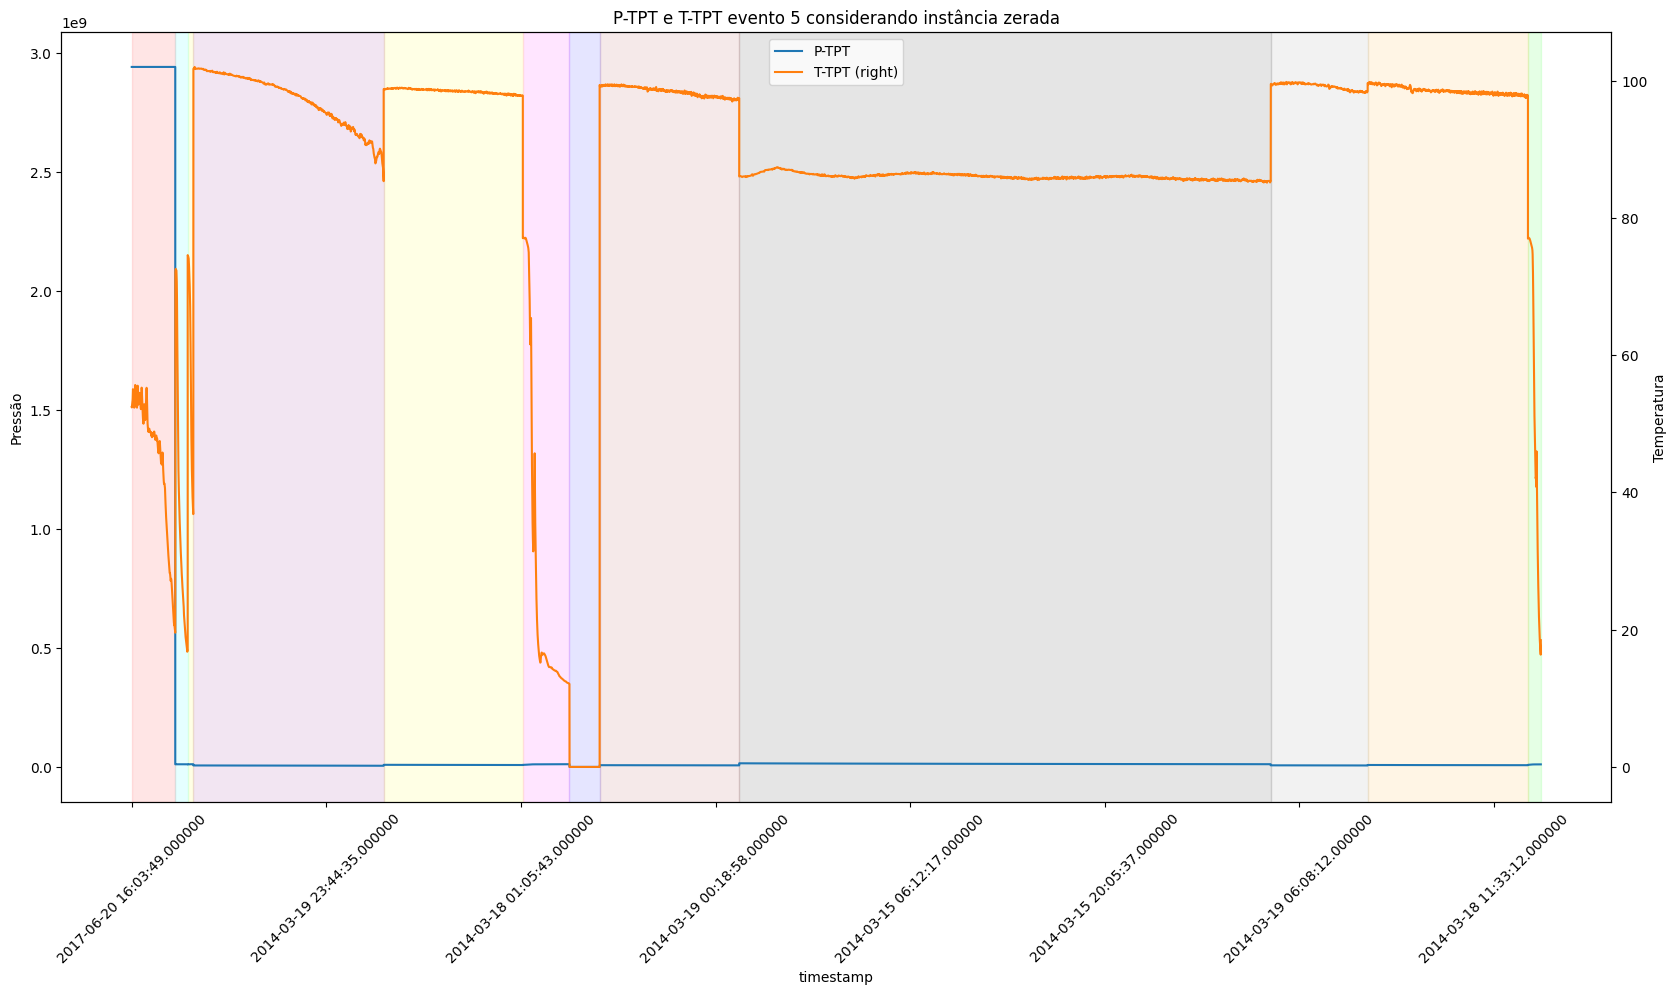

In [27]:


exclude_columns=['P-PDG','P-MON-CKP','T-JUS-CKP','P-JUS-CKGL','QGL','file_name']

PRP_PTPT_TTPT_WITH_ZERO:DataFrame = PRP.drop(
    columns=exclude_columns
    ).copy()

ax = PRP_PTPT_TTPT_WITH_ZERO.plot(secondary_y=['T-TPT'],x='timestamp',rot=45,figsize=(20,10))

ax.set_ylabel('Pressão')
ax.right_ax.set_ylabel('Temperatura')
ax.set_title('P-TPT e T-TPT evento 5 considerando instância zerada')
dfs_by_file_name = [
    PRP[PRP['file_name']==file_name]
    for file_name in list(files_and_sizes['file_name'])
]



x_map = {val:i for i,val in enumerate(list(PRP_PTPT_TTPT_WITH_ZERO['timestamp']))}

instancesSpan(PRP_PTPT_TTPT_WITH_ZERO,x_map)


- Plot P-TPT by timestamp, excluding the instance `WELL-00015_20171013140047.csv`.

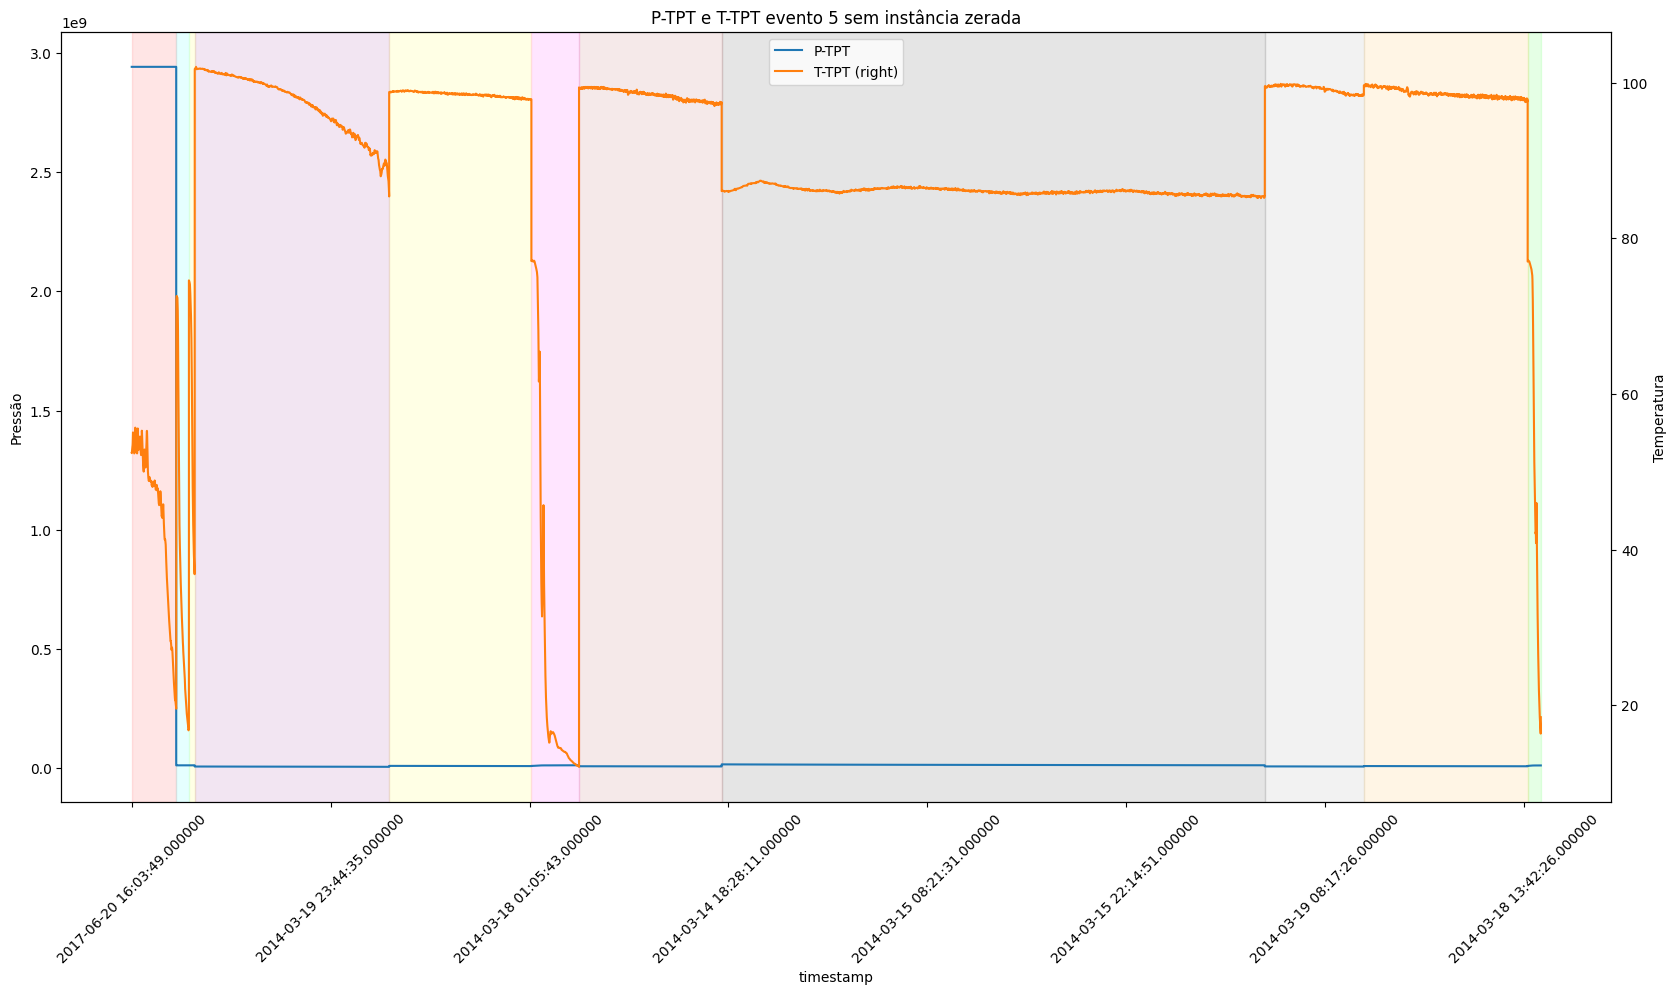

In [28]:

exclude_columns=['P-PDG','P-MON-CKP','T-JUS-CKP','P-JUS-CKGL','QGL','file_name']

PRP_PTPT_TTPT:DataFrame = PRP.drop(
    PRP[PRP['file_name']==instance_with_P_T_zeros].index
    ).drop(
    columns=exclude_columns
    ).copy()

ax = PRP_PTPT_TTPT.plot(secondary_y=['T-TPT'],x='timestamp',rot=45,figsize=(20,10))

ax.set_ylabel('Pressão')
ax.right_ax.set_ylabel('Temperatura')
ax.set_title('P-TPT e T-TPT evento 5 sem instância zerada')

dfs_by_file_name = [
    PRP[PRP['file_name']==file_name]
    for file_name in list(files_and_sizes['file_name'])
]


x_map = {val:i for i,val in enumerate(list(PRP_PTPT_TTPT['timestamp']))}

instancesSpan(PRP_PTPT_TTPT,x_map)


- Behavior of QGL
Observing the occurrence of zero values and the behavior of the QGL variable across the 12 instances.

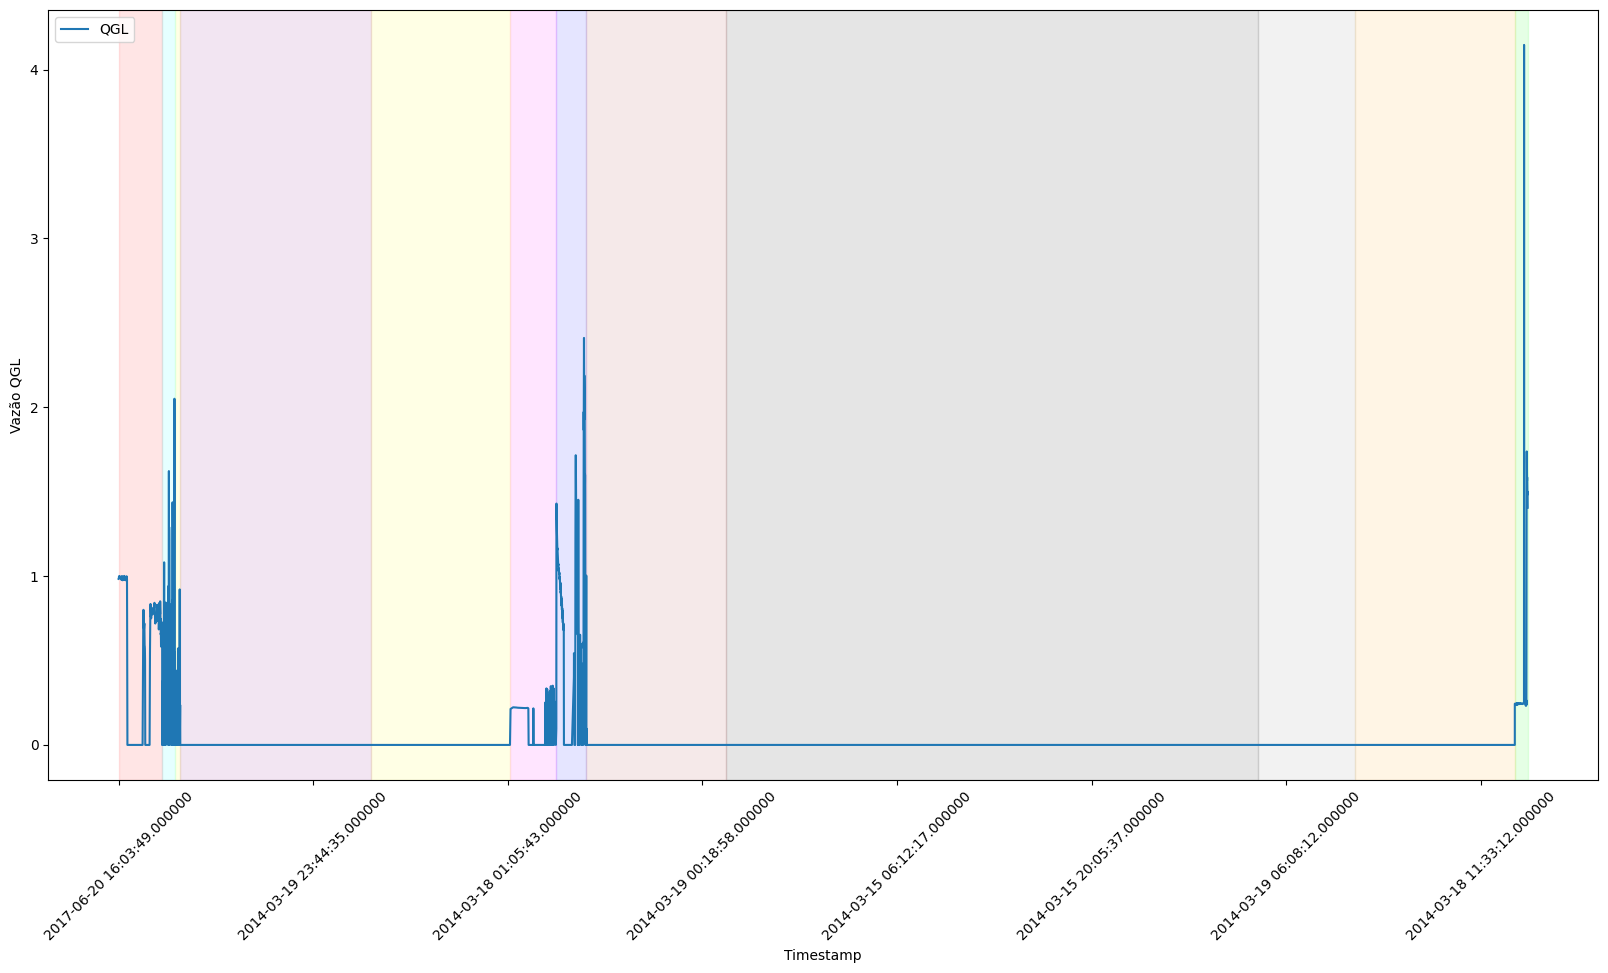

In [29]:
PRP_QGL = PRP[['timestamp','QGL']].copy()
ax = PRP_QGL.plot(x='timestamp',rot=45,figsize=(20,10))

x_map = {val:i for i,val in enumerate(list(PRP_QGL['timestamp']))}
ax.set_ylabel('Vazão QGL')
ax.set_xlabel('Timestamp')


instancesSpan(PRP_QGL,x_map)

As much of the data in QGL consists of zeros, it is worth considering removing it.

---

**Plots for visual understanding:**

* Pressures: P-PDG , P-TPT,P-MON-CKP,P-JUS-CKGL 

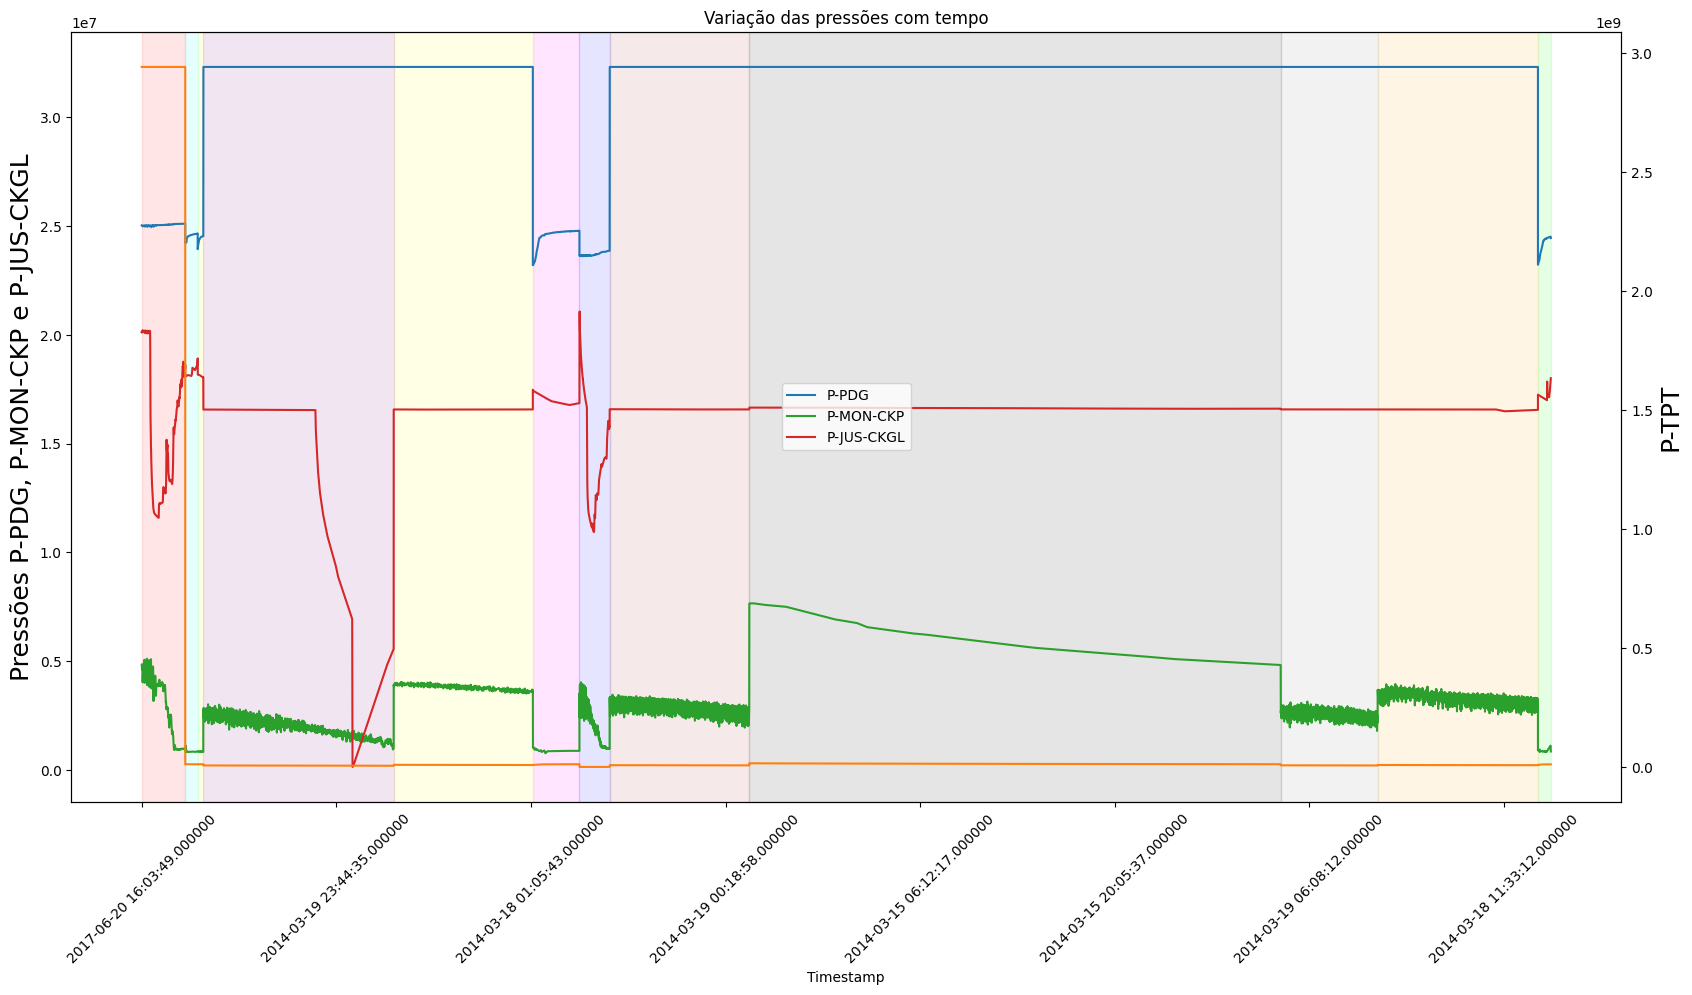

In [35]:
P_df = PRP[['timestamp','P-PDG','P-TPT','P-MON-CKP','P-JUS-CKGL']].copy() # Dataframe de pressões
ax = P_df.plot(x='timestamp',secondary_y='P-TPT',figsize=(20,10),rot=45)


ax.set_title('Variação das pressões com tempo')
ax.set_xlabel('Timestamp')
ax.right_ax.set_ylabel('P-TPT',fontsize=18)
ax.set_ylabel('Pressões P-PDG, P-MON-CKP e P-JUS-CKGL',fontsize=18)
ax.legend(loc='center')
x_map = {val:i for i,val in enumerate(list(P_df['timestamp']))}
instancesSpan(P_df,x_map)

* Temperaturas: T-TPT, T-JUS-CKP

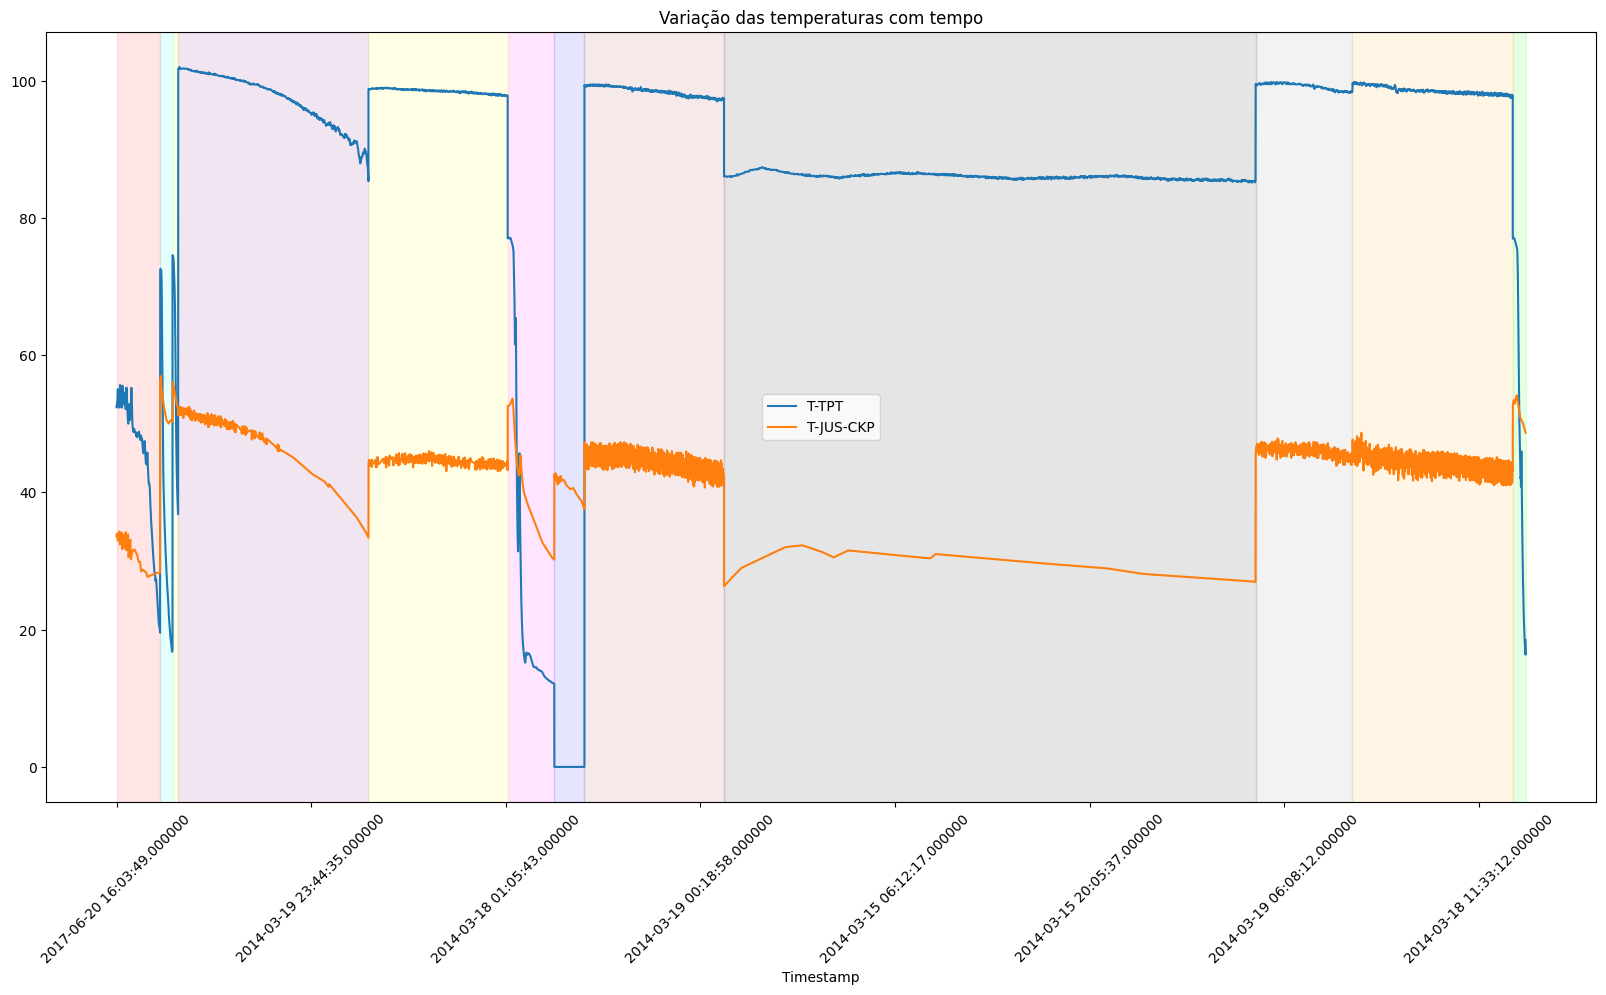

In [31]:
T_df = PRP[['timestamp','T-TPT','T-JUS-CKP']].copy() # Dataframe de temperaturas
ax = T_df.plot(x='timestamp',figsize=(20,10),rot=45)


ax.set_title('Variação das temperaturas com tempo')
ax.set_xlabel('Timestamp')
ax.legend(loc='center')
x_map = {val:i for i,val in enumerate(list(T_df['timestamp']))}
instancesSpan(T_df,x_map)

# NaN class

It would be interesting to fill NaN values with one of the three viable options in the process (0, 105, or 5). 

The following logic can be followed to fill NaN values in classes:

1) If NaN is between 0 and 105, it can be considered as 0 since it is likely the beginning of a failure operation.

2) If NaN is between constant values, fill it with the same constant value, as it is a historical series and the most natural assumption is that the operation follows its linearity.

3) If NaN is between 105 and 5, consider it as a failure operation, as it is the most reasonable understanding of the issues.

Another identification to consider is that every scenario of 105 is 5.

If there are many consecutive NaN values, it is interesting to understand how to fill those values according to the real instances and identify if those values represent a normal operation. --> This will be disregarded for now.



## Observing NaN ocurrences.

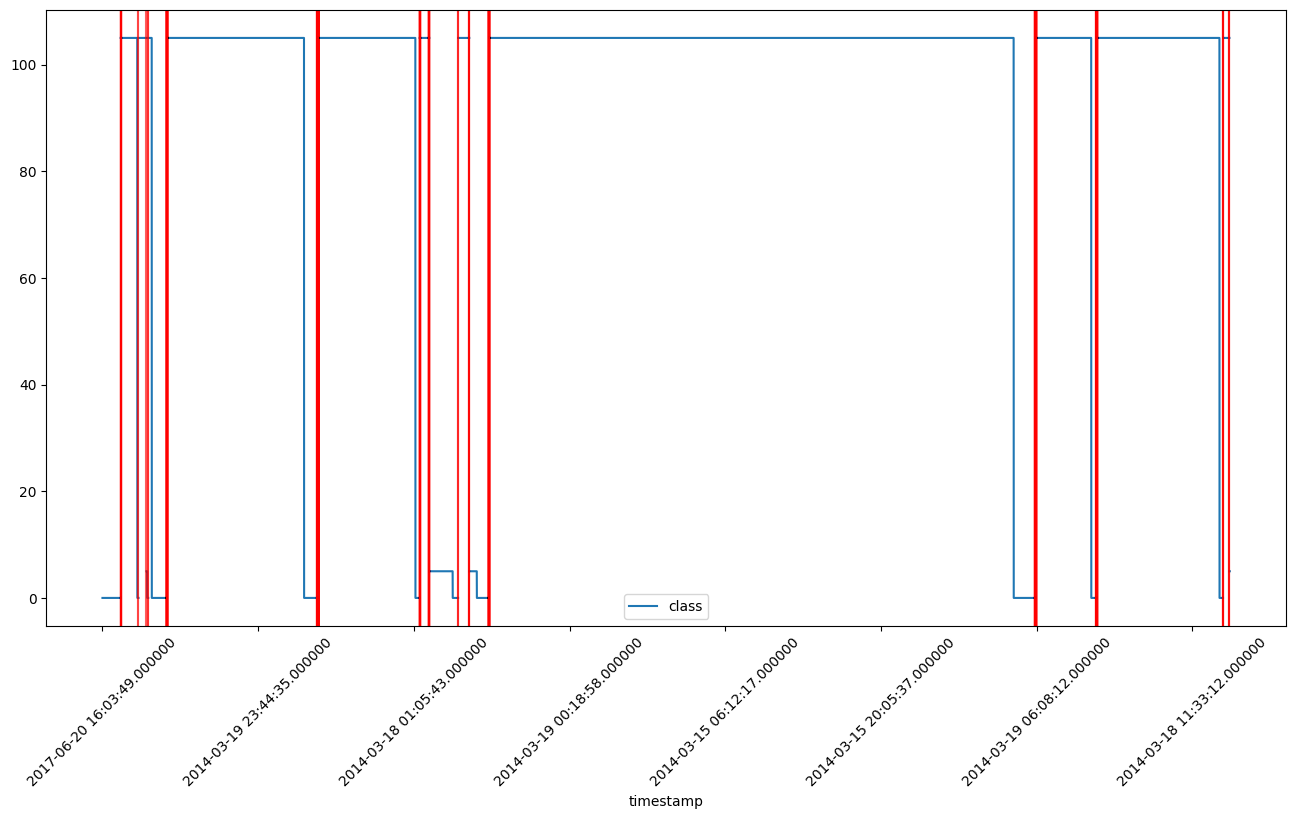

In [32]:
class_df =PRP_with_class[['timestamp','class']].copy() 
ax = class_df.plot(x='timestamp',figsize=(16,8), rot=45)
x_map = {val:i for i,val in enumerate(list(T_df['timestamp']))}

mask = class_df.isna().any(axis=1)
nan_indexes = list(np.where(mask)[0])

for index in nan_indexes:
  ax.axvline(index, color='r',alpha=0.1)




## Filling NaN values

First, let's replace all occurrences of 105 with 5, considering that the transition to a failure is already indicative enough for the identification of an adverse event. That's an author's assumption


List of PRP Dataframes that contain only classes 0 and 5 (Normal and Failure).

In [33]:
PRP_norm_fal = []
for df in dfs_by_instances:
  classes = df['class'].replace(105,5)
  new_df = df.assign(**{'class':classes})
  PRP_norm_fal.append(new_df)

Filling the Nan values with the next nearest valid value of `class` 

In [34]:
PRP_filled_na = [df.fillna(method='ffill') for df in PRP_norm_fal]

Plot new graphic with NaN values filled

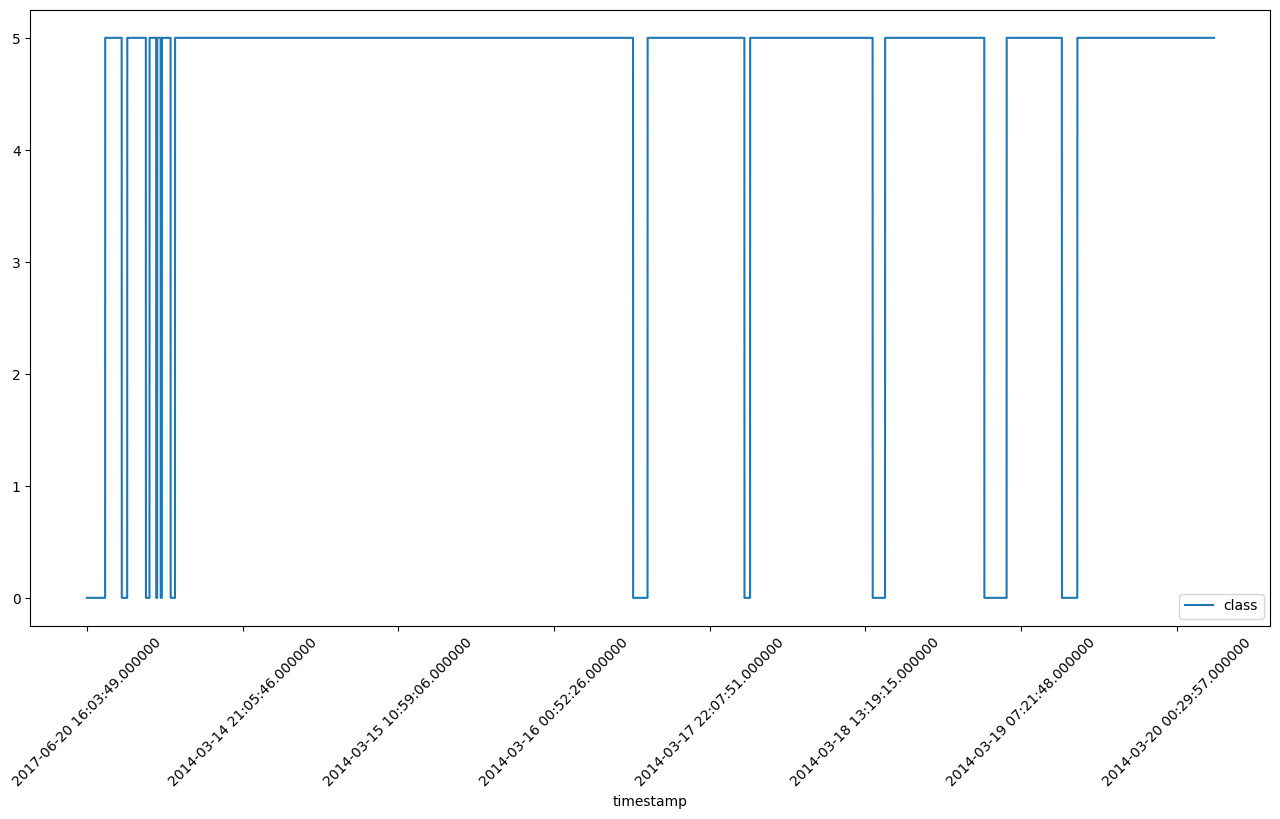

In [37]:
class_df_filled_na =pd.concat(PRP_filled_na)[['timestamp','class']].copy() 
ax = class_df_filled_na.plot(x='timestamp',figsize=(16,8), rot=45)


It is important to note that the sixth instance only presented data for failures (class 5), as previously there were only data for events transitioning to failure and failure itself.

# **HeatMaps - After NaN removal**



For the new heat map plots, NaN values have been filled, and the QGL variable has been disregarded as it does not demonstrate a consistent behavior pattern. Additionally, QGL represents gas lift flow, which is not applicable to the process.

In [38]:
PRP_treated = pd.concat(PRP_filled_na)
PRP_treated = PRP_treated.drop(columns=['QGL']).copy()

--- 
**Spearman Correlation** 

In [39]:
corr_spearman_treated = PRP_treated.iloc[:,:].corr(method='spearman')

/tmp/ipykernel_425790/3621596213.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_spearman_treated = PRP_treated.iloc[:,:].corr(method='spearman')


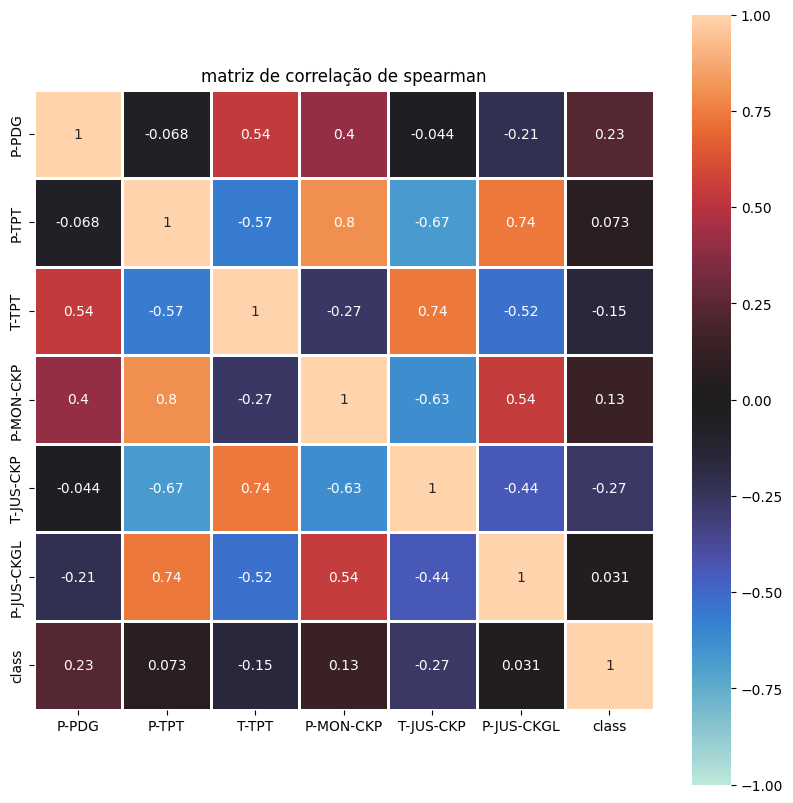

In [40]:

fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(corr_spearman_treated,
                 vmin=-1, 
                 vmax=1, 
                 center=0,
                 square=True,
                 annot=True,
                 linewidths=0.8) 
ax.set_ylim(len(corr_spearman_treated), 0) 
plt.title('matriz de correlação de spearman')
plt.show()

**Kendall Correlation**

In [41]:
corr_kendall_treated = PRP_treated.iloc[:,:].corr(method='kendall')


/tmp/ipykernel_425790/3237902190.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_kendall_treated = PRP_treated.iloc[:,:].corr(method='kendall')
/home/rforonda@hu.corp/Documentos/Personal/PUC/TCC/3W_EVALUATION/venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


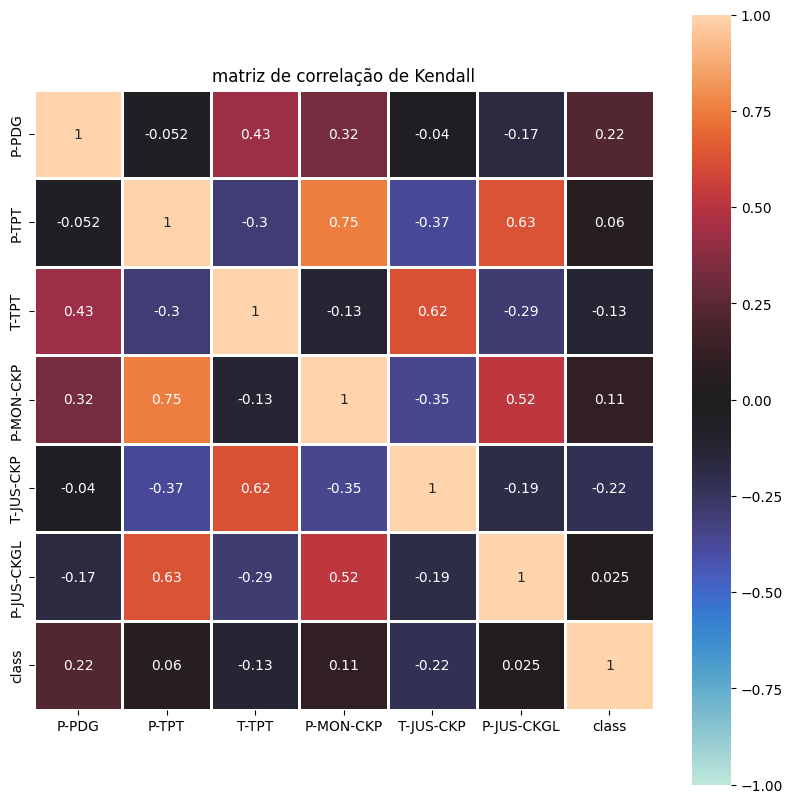

In [42]:
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(corr_kendall_treated,
                 vmin=-1, 
                 vmax=1, 
                 center=0,
                 square=True,
                 annot=True,
                 linewidths=0.8) 
ax.set_ylim(len(corr_kendall_treated), 0)
plt.title('matriz de correlação de Kendall')
plt.show()

---
# **Lasso Regression**


In [43]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Lasso regression is a well know Logistic Regression with penalty of type L1. For this work, the Lasso methods from linear_model.Lasso and linear_model.LogisticRegression with penalty 'l1'  were performed for comparison.  

For the Lasso model, the values of X are the predictor variables that will be used for prediction, while Y represents the resulting classes. Therefore, it is natural that X corresponds to the process variables, and Y corresponds to the 'class' variable.

In [44]:
X = PRP_treated[['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP','P-JUS-CKGL']]
y = PRP_treated[['class']]

- Data Normalization

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
scaler = StandardScaler()
scaler.fit(X_train)
X_trainn = scaler.transform(X_train)

- Scikilearn Lasso

In [52]:
lasso = Lasso(alpha=0.1)

lasso.fit(X_trainn, y_train)
lasso_scikit_learn = lasso.coef_
lasso_scikit_learn 

array([ 0.06932256, -0.30793674, -0.        , -0.        , -0.31139162,
       -0.00661635])

* Scikitlearn LogisticRegression with penalty l1

In [55]:
sel_ = LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10)
sel_.fit(X_trainn, y_train)
lasso_logistic_reg = sel_.coef_
lasso_logistic_reg

/home/rforonda@hu.corp/Documentos/Personal/PUC/TCC/3W_EVALUATION/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[ 0.52316965, -1.43658068,  0.0049172 , -2.41472029, -3.96992968,
        -0.10163144]])

In [57]:
coef_df = pd.DataFrame(data = {'features':['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP','P-JUS-CKGL'],'scikit_learn':lasso_scikit_learn,'logistic_regression':lasso_logistic_reg[0]})
coef_df

,features,scikit_learn,logistic_regression
0,P-PDG,0.069323,0.523170
1,P-TPT,-0.307937,-1.436581
2,T-TPT,-0.000000,0.004917
3,P-MON-CKP,-0.000000,-2.414720
4,T-JUS-CKP,-0.311392,-3.969930
5,P-JUS-CKGL,-0.006616,-0.101631


# **PCA - Principal Component Analysis**

Using Prince, the principal component analysis (PCA) method was performed.

In [58]:
pca = prince.PCA( n_components=6,
                  n_iter=10,
                  rescale_with_mean=True,
                  rescale_with_std=True,
                  copy=True,
                  check_input=True,
                  engine='sklearn',
                  random_state=200 )

In [59]:
pca = pca.fit(PRP_treated.drop(columns = ['class','timestamp','file_name']))

In [60]:
pca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,2.322,38.70%,38.70%
1,1.780,29.67%,68.36%
2,1.016,16.93%,85.30%
3,0.708,11.80%,97.10%
4,0.138,2.29%,99.39%
5,0.037,0.61%,100.00%


In [61]:
pca.column_contributions_.style.format('{:.0%}')

component,0,1,2,3,4,5
variable,,,,,,
P-PDG,40%,0%,2%,2%,9%,46%
P-TPT,15%,5%,2%,75%,0%,2%
T-TPT,32%,6%,0%,19%,0%,43%
P-MON-CKP,12%,37%,0%,0%,51%,0%
T-JUS-CKP,0%,47%,9%,2%,33%,8%
P-JUS-CKGL,1%,5%,86%,2%,6%,0%


In [62]:
pca.column_correlations

component,0,1,2,3,4,5
variable,,,,,,
P-PDG,-0.962389,-0.069078,0.148355,0.131297,-0.114208,-0.129398
P-TPT,0.593115,0.308672,0.148484,0.727980,0.005866,-0.029976
T-TPT,-0.864866,-0.320295,0.046353,0.362556,0.000045,0.125790
P-MON-CKP,-0.527169,0.806686,-0.024024,-0.021714,0.264903,-0.011365
T-JUS-CKP,0.073946,-0.914332,-0.306380,0.126963,0.213419,-0.054710
P-JUS-CKGL,-0.112004,0.300879,-0.935563,0.113301,-0.093870,-0.000836


By PCA, considering 85% of significance, it's possible to say that P-TPT and P-MON-CKP can be unrelevant for the prediction of a model. 

---
# Outliers Analysis


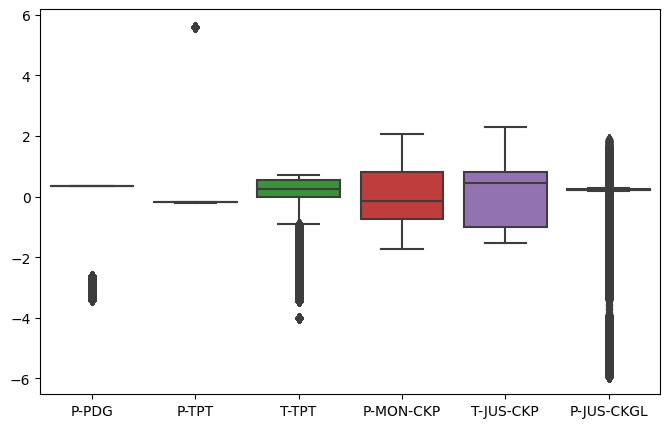

In [63]:
X = PRP_treated.drop(columns=['class','timestamp','file_name'],axis=1)
Y = PRP_treated['class']

scaler = StandardScaler() 
X_scaler = scaler.fit_transform(X)

fig = plt.figure(figsize=(8, 5))
sns.boxplot(data=pd.DataFrame(X_scaler, columns = PRP_treated.drop(columns = ['class','timestamp','file_name']).columns))


plt.show()

# Save data for next processes

In [ ]:
PRP_treated.to_csv('./PRP_treated_data.csv')

- Divide test and train data

In [76]:
data = np.array(PRP_df)
data4 = data[:,8:9]

in_1 = PRP_treated.drop(columns=['timestamp','class','file_name'],axis=1).copy() # LogisticRegression with l1 penalty
in_2 = PRP_treated.drop(columns=['timestamp','T-TPT', 'P-MON-CKP','class','file_name'],axis=1).copy() # ScikitLearn Lasso method
in_3 = PRP_treated.drop(columns=['timestamp','P-TPT', 'P-MON-CKP','class','file_name'],axis=1).copy() # PCA
out = pd.DataFrame(data4)

In [ ]:

train_in1,test_in1,train_out1,test_out1 = train_test_split(in_1,out,test_size=0.3)
train_in2,test_in2,train_out2,test_out2 = train_test_split(in_2,out,test_size=0.3)
train_in3,test_in3,train_out3,test_out3 = train_test_split(in_3,out,test_size=0.3)

Merge In and Out for saving: 

In [78]:
train1 = pd.concat([train_in1.copy(),train_out1.copy()],axis=1)
train2 = pd.concat([train_in2.copy(),train_out2.copy()],axis=1)
train3 = pd.concat([train_in3.copy(),train_out3.copy()],axis=1)
test1 = pd.concat([test_in1.copy(),test_out1.copy()],axis=1)
test2 = pd.concat([test_in2.copy(),test_out2.copy()],axis=1)
test3 = pd.concat([test_in3.copy(),test_out3.copy()],axis=1)

In [91]:
from utils import  save_csv_if_doesnt_exist

In [94]:
save_csv_if_doesnt_exist(train1,'./feature_selection_results/train1.csv')
save_csv_if_doesnt_exist(train2,'./feature_selection_results/train2.csv')
save_csv_if_doesnt_exist(train3,'./feature_selection_results/train3.csv')
save_csv_if_doesnt_exist(test1,'./feature_selection_results/test1.csv')
save_csv_if_doesnt_exist(test2,'./feature_selection_results/test2.csv')
save_csv_if_doesnt_exist(test3,'./feature_selection_results/test3.csv')